In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')


from sklearn import datasets
from tqdm.auto import tqdm

import scipy.stats as sc

In [2]:
# Getting the data

iris = datasets.load_iris()
y = iris.target
columns=iris.feature_names
X = iris.data
df=pd.DataFrame(X,columns=columns)
df['target'] = y
X = df.drop('target',axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Aproach
    1. Select the k most central points as seed
    2. Select the data points which add the most distance when compared to all the points in the cluster
    3. Terminate when the data points run out

In [3]:
k = 2
C = dict()
for cluster in range(k):
    C[cluster] = pd.DataFrame()

## 1. Intialization
#### 1.1 Calculating the mean vector

In [4]:
# Calculating the seed vector

mean_vector = X.mean()

#### 1.2 Calculating the distance from mean vector and sorting it

In [5]:
X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mean_vector)), axis=1)
dist_means = X.sort_values(by='dist_mean')
idx_to_drop = dist_means.index[:k]
dist_means.reset_index(drop=True,inplace=True)
X.drop('dist_mean',axis=1,inplace=True)
X.drop(idx_to_drop, inplace=True)
dist_means.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),dist_mean
0,5.6,2.9,3.6,1.3,0.345055
1,5.8,2.7,3.9,1.2,0.386949


#### 1.3 Assigning seed points to cluster

In [6]:
mu = list()
for cluster in range(k):
    C[cluster] = C[cluster].append(dist_means.iloc[cluster].drop('dist_mean'))
    mu.append(C[cluster].mean())
C[0]

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
0,3.6,1.3,5.6,2.9


## 2. Cluster Assignment

In [7]:
y = iris.target
columns=iris.feature_names
X = iris.data
df=pd.DataFrame(X,columns=columns)
df['target'] = y
X = df.drop('target',axis=1)

pval = dict()
for cluster in range(k):
    pval[cluster] = dict()
    for i in C[0].columns:
        pval[cluster][i] = list()


for i in tqdm(range(int(len(X)/k)), desc='Iterations: '):
    for cluster in range(k):

        # Calculating the distances from the mean vector of each cluster (in Descending order)
        X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mu[cluster])), axis=1)
        dist_means = X.sort_values(by='dist_mean', ascending=False)
        idx_to_drop = dist_means.index[0]
        dist_means.reset_index(drop=True,inplace=True)
        X.drop('dist_mean',axis=1,inplace=True)

        # Assigning the top value to the cluster
        C[cluster] = C[cluster].append(dist_means.iloc[0].drop('dist_mean'))
        C[cluster] = C[cluster].reset_index(drop=True)
        
        # Updating means of each cluster
        mu[cluster] = C[cluster].mean()

        # Remove datapoint from X?
        X.drop(idx_to_drop,inplace=True)
        
        for i in C[0].columns:
            pval[cluster][i].append(sc.ks_2samp(C[cluster][i],df.drop('target',axis=1)[i])[1])

### 3. Plotting the result

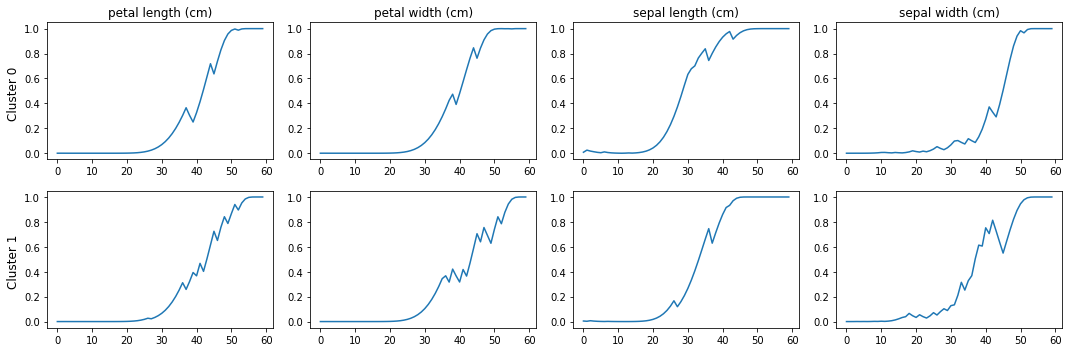

In [8]:
fig, axes = plt.subplots(k, len(C[0].columns), figsize=(15,5))

# Plotting the KS p-value
for cluster in range(k):
    for i,j in enumerate(C[0].columns):
        axes[cluster, i].plot(pval[cluster][j][15:])

# Setting columns headers
for ax, col in zip(axes[0], C[0].columns):
    ax.set_title(col)

# Setting row titles
for ax, row in zip(axes[:,0], range(k)):
    ax.set_ylabel("Cluster {} ".format(row), rotation=90, size='large')
        
plt.tight_layout()
plt.show()      